# Channel  Quality Assessment, Pruning, and Motion Artifact Detection: Example Notebook (WIP)

This notebook sketches how to prune bad channels and detect motion artefacts in fNIRS data

In [1]:
import cedalion
import cedalion.nirs
import cedalion.sigproc.quality as quality
import cedalion.xrutils as xrutils
import cedalion.datasets as datasets
import xarray as xr
import matplotlib.pyplot as p

from cedalion import Quantity, units

### Loading raw CW-NIRS data from a SNIRF file and converting it to OD and CONC

This notebook uses a finger-tapping dataset in BIDS layout provided by Rob Luke that is automatically fetched. 
You can also find it [here](https://github.com/rob-luke/BIDS-NIRS-Tapping).

,sourceIndex,detectorIndex,wavelengthIndex,wavelengthActual,wavelengthEmissionActual,dataType,dataUnit,dataTypeLabel,dataTypeIndex,sourcePower,detectorGain,moduleIndex,sourceModuleIndex,detectorModuleIndex,channel,source,detector,wavelength,chromo
0,1,1,1,None,None,1,None,None,1,None,None,None,None,None,S1D1,S1,D1,760.0,None
1,1,1,2,None,None,1,None,None,1,None,None,None,None,None,S1D1,S1,D1,850.0,None
2,1,2,1,None,None,1,None,None,1,None,None,None,None,None,S1D2,S1,D2,760.0,None
3,1,2,2,None,None,1,None,None,1,None,None,None,None,None,S1D2,S1,D2,850.0,None
4,1,3,1,None,None,1,None,None,1,None,None,None,None,None,S1D3,S1,D3,760.0,None
5,1,3,2,None,None,1,None,None,1,None,None,None,None,None,S1D3,S1,D3,850.0,None
6,1,9,1,None,None,1,None,None,1,None,None,None,None,None,S1D9,S1,D9,760.0,None
7,1,9,2,None,None,1,None,None,1,None,None,None,None,None,S1D9,S1,D9,850.0,None
8,2,1,1,None,None,1,None,None,1,None,None,None,None,None,S2D1,S2,D1,760.0,None
9,2,1,2,None,None,1,None,None,1,None,None,None,None,None,S2D1,S2,D1,850.0,None


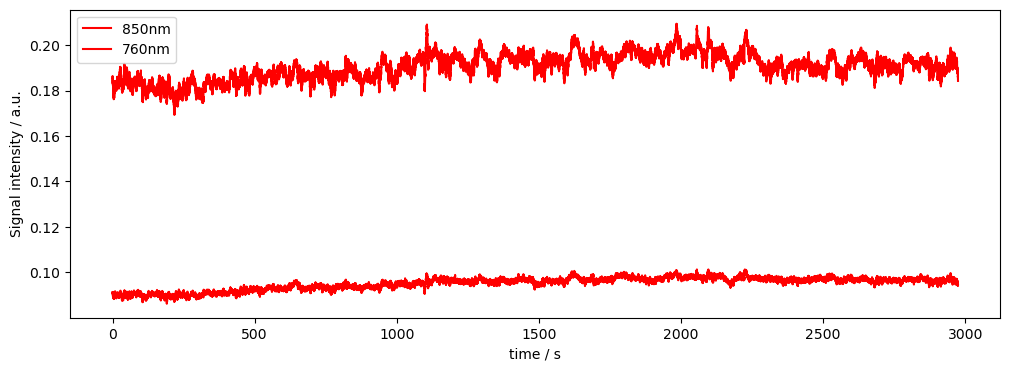

In [6]:
# get example finger tapping dataset

snirf_element = datasets.get_fingertapping()
amp = snirf_element[0].data[0]
geo = snirf_element[0].geo3d
od = cedalion.nirs.int2od(amp)
# ml = snirf_element[0].measurement_lists[0]

data = xr.Dataset(
    data_vars = {
        "amp" : amp,
        "od"  : od,
        "geo3d": geo
    })


# Plot some data for visual validation
f,ax = p.subplots(1,1, figsize=(12,4))
ax.plot( data.amp.time, data.amp.sel(channel="S1D1", wavelength="850"), "r-", label="850nm")
ax.plot( data.amp.time, data.amp.sel(channel="S1D1", wavelength="760"), "r-", label="760nm")
p.legend()
ax.set_xlabel("time / s")
ax.set_ylabel("Signal intensity / a.u.")

### Channel Pruning
Display the use of small helper functions to assess individual channel quality criteria, or the use of the "prune" function to apply any or all of them to obtain a measurement list of only good channels. 

In [3]:
# we can assess channel quality by the following metrics. More will follow
snr_thresh = 20 # the SNR (std/mean) of a channel. Set high here for demonstration purposes
amp_threshs = [0.1, 3]*units.volt # whether a channel's amplitude is within a certain range
sd_threshs = [1, 4.5]*units.cm # whether a channels distance is within a certain range


'''the following functions assess the above criteria individually and return a measurement list (MeasList)
that contains only channels that meet the criteria'''

# SNR thresholding
snr, meas_list_snr, drop_list_snr = quality.snr_range(data.amp, snr_thresh)

print(f"The channels passing the snr threshold are: {meas_list_snr}")
print(f"The channels failing the snr threshold are: {drop_list_snr}")

# Source Detector Separation thresholding
ch_dist, meas_list_sd, drop_list_sd = quality.sd_range(data.amp, data.geo3d, sd_threshs)

print(f"The channels passing the SD distance thresholds are: {meas_list_sd}")
print(f"The channels failing the SD distance thresholds are: {drop_list_sd}")

# Amplitude thresholding
meas_list_amp, drop_list_amp = quality.amp_range(data.amp, amp_threshs)

print(f"The channels passing the amplitude thresholds are: {meas_list_amp}")
print(f"The channels failing the amplitude thresholds are: {drop_list_amp}")



'''To comprehensively prune channels from the dataset across criteria, we can use the quality.prune 
function that incorporates all the above helper functions'''

data_pruned, drop_list = quality.prune(data.amp, data.geo3d, snr_thresh, amp_threshs, sd_threshs)
print(f"The channels passing all thresholds are: {data_pruned.coords['channel'].values}")
print(f"The channels failing any or all thresholds are: {drop_list}")


The channels passing the snr threshold are: ['S1D1', 'S1D2', 'S1D3', 'S1D9', 'S2D1', 'S2D3', 'S2D4', 'S2D10', 'S3D2', 'S3D3', 'S3D11', 'S4D3', 'S4D12', 'S5D5', 'S5D6', 'S5D13', 'S6D7', 'S6D14', 'S7D15', 'S8D7', 'S8D16']
The channels failing the snr threshold are: ['S4D4' 'S5D7' 'S6D5' 'S6D8' 'S7D6' 'S7D7' 'S8D8']
The channels passing the SD distance thresholds are: ['S1D1', 'S1D2', 'S1D3', 'S2D1', 'S2D3', 'S2D4', 'S3D2', 'S3D3', 'S4D3', 'S4D4', 'S5D5', 'S5D6', 'S5D7', 'S6D5', 'S6D7', 'S6D8', 'S7D6', 'S7D7', 'S8D7', 'S8D8']
The channels failing the SD distance thresholds are: ['S1D9' 'S2D10' 'S3D11' 'S4D12' 'S5D13' 'S6D14' 'S7D15' 'S8D16']
The channels passing the amplitude thresholds are: ['S1D1', 'S1D2', 'S1D3', 'S1D9', 'S2D1', 'S2D3', 'S2D4', 'S2D10', 'S3D2', 'S3D3', 'S3D11', 'S4D3', 'S4D4', 'S4D12', 'S5D5', 'S5D6', 'S5D7', 'S5D13', 'S6D5', 'S6D7', 'S6D8', 'S6D14', 'S7D6', 'S7D7', 'S7D15', 'S8D7', 'S8D8', 'S8D16']
The channels failing the amplitude thresholds are: []
The channels pas

### Motion Artefact Detection
Exemplifies how to checks channels for motion artefacts using standard thresholds from Homer2/3

In [4]:
# Coming soon